In [1]:
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import popy.config as cfg

from popy.io_tools import load_behavior, load_neural_data, load_metadata
#from popy.dim_reduction import *
from popy.decoding.decoder_tools import build_dataset
from popy.plotting.plotting_tools import plot_keypoints
from popy.behavior_data_tools import add_value_function, add_switch_info, add_value_anna
from popy.neural_data_tools import remove_trunctuated_neurons, time_normalize_session, scale_neural_data

from sklearn.decomposition import PCA
import pandas as pdr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import popy.config as cfg
import os
PATH = cfg.PROJECT_PATH_LOCAL


def plot_single_unit(unit_data, labels, condition=None, title=None, ax=None):
    time_vector = unit_data.time.data

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))

    # get mean counts by condition
    mean_counts = {label: np.mean(unit_data[labels == label], axis=0) for label in np.unique(labels)}
    std_counts = {label: np.std(unit_data[labels == label], axis=0) for label in np.unique(labels)}
    sem_counts = {label: np.std(unit_data[labels == label], axis=0) / np.sqrt(np.sum(labels == label)) for label in np.unique(labels)}

    # plot trial-avg rates by condition
    for label in np.unique(labels):
        ax.plot(time_vector, mean_counts[label], label=f'{int(label)}, N={np.sum(labels == label)}')
        ax.fill_between(time_vector, mean_counts[label] - sem_counts[label], mean_counts[label] + sem_counts[label], alpha=.1)

    plot_keypoints(ax)

    ax.set_xlabel('time (s)')
    ax.set_ylabel('firing rate (Hz)')
    # grid on x axis only
    ax.grid(alpha=.3, axis='x')
    if condition is not None:
        ax.legend(title=condition, loc='upper right')
    #ax.axhline(0, color='k', alpha=.5) # add zero line

    # Add a box at the top left corner
    x_loc = time_vector[0]
    y_loc = ax.get_ylim()[1] 
    y_loc_text = y_loc - (ax.get_ylim()[1] - ax.get_ylim()[0]) * .18
    y_loc_line = y_loc - (ax.get_ylim()[1] - ax.get_ylim()[0]) * .2

    ax.text(x_loc+.5, y_loc_text, '1s', verticalalignment='bottom', horizontalalignment='center')

    # Plot a unit length horizontal line inside the box
    ax.plot([x_loc, x_loc + 1], [y_loc_line, y_loc_line], color='black')
    ax.scatter([x_loc, x_loc + 1], [y_loc_line, y_loc_line], marker='|', color='black')

    # remove top and right spines
    sns.despine()

    if title is not None:
        ax.set_title(title)


# Load data

In [2]:
# load data, neural and behavioral
monkey, session = 'ka', '210322'
area = 'MCC'

In [3]:
# load behavioral data
session_data = load_behavior()
session_data = session_data[(session_data['monkey'] == monkey) & (session_data['session'] == session)]
session_data = add_value_function(session_data, monkey=monkey, digitize=False, n_classes=4)
session_data.rename(columns={'value_function': 'value_function_continuous'}, inplace=True)
session_data = add_value_function(session_data, monkey=monkey, digitize=True, n_classes=4)
session_data = add_value_anna(session_data, model='fss_01', digitize=False, n_classes=4)
session_data.rename(columns={'fss_01': 'fss_01_continuous'}, inplace=True)
session_data = add_value_anna(session_data, model='fss_01', digitize=True, n_classes=4)

session_data = session_data.dropna()

print({i: np.count_nonzero(session_data['value_function'] == i) for i in np.unique(session_data['value_function'])})
print({i: np.count_nonzero(session_data['fss_01'] == i) for i in np.unique(session_data['fss_01'])})
session_data

{0.0: 96, 1.0: 108, 2.0: 104, 3.0: 112}
{0: 102, 1: 105, 2: 104, 3: 109}


monkey session  trial_id  trial_start_time  lever_touch_time  \
5       ka  210322         5           92.9438           96.5955   
6       ka  210322         6          103.5147          104.4274   
7       ka  210322         7          111.3513          111.4181   
8       ka  210322         8          118.3571          120.3034   
9       ka  210322         9          127.5238          128.0906   
..     ...     ...       ...               ...               ...   
420     ka  210322       420         3238.6717         3243.4172   
421     ka  210322       421         3251.2281         3251.2949   
422     ka  210322       422         3258.3208         3258.5950   
423     ka  210322       423         3265.1677         3265.2610   
424     ka  210322       424         3271.7916         3272.9618   

     lever_validation_time  lever_release_time  target_touch_time  \
5                  97.6094             98.0414            98.4584   
6                 105.4474            105.9029           106.2717   
7                 112.4323            112.7769           113.1047   
8                 121.3187            121.5382           121.8218   
9                 129.1029            129.2070           129.4785   
..                     ...                 ...                ...   
420              3244.4297           3244.5638          3246.1735   
421              3252.3183           3252.7113          3252.9564   
422              3259.6093           3259.8254          3260.0612   
423              3266.2756           3266.3684          3266.7138   
424              3273.9774           3274.3817          3274.6476   

     target_validation_time  feedback_time  ...  block_id  best_target  \
5                   98.9755        99.4907  ...         0            1   
6                  106.7998       107.3146  ...         0            1   
7                  113.6248       114.1388  ...         0            1   
8                  122.3666       122.8806  ...         0            1   
9                  130.0468       130.5602  ...         0            1   
..                      ...            ...  ...       ...          ...   
420               3246.6890      3247.2010  ...         9            3   
421               3253.4860      3253.9991  ...         9            3   
422               3260.6344      3261.1424  ...         9            3   
423               3267.2552      3267.7703  ...         9            3   
424               3275.2153      3275.7390  ...         9            3   

     target  feedback  value_function_continuous  proba_shift   entropy  \
5       2.0       1.0                   0.145032     0.871101  0.554412   
6       2.0       0.0                   0.549370     0.128483  0.553263   
7       2.0       0.0                   0.305599     0.540544  0.995252   
8       3.0       0.0                   0.145032     0.871101  0.554412   
9       1.0       1.0                   0.080677     0.917608  0.410553   
..      ...       ...                        ...          ...       ...   
420     3.0       1.0                   0.854968     0.006647  0.057634   
421     3.0       0.0                   0.919323     0.004044  0.037971   
422     3.0       0.0                   0.486429     0.194346  0.710475   
423     3.0       0.0                   0.270587     0.613338  0.962611   
424     2.0       1.0                   0.125555     0.858842  0.587264   

     value_function  fss_01_continuous  fss_01  
5               0.0          -1.950794       0  
6               2.0           6.719891       1  
7               0.0           3.305358       0  
8               0.0          -2.414035       0  
9               0.0          -1.027660       0  
..              ...                ...     ...  
420             3.0          13.306677       3  
421             3.0          14.494267       3  
422             1.0           7.249294       1  
423             0.0           3.608196       0  
424             0.0          

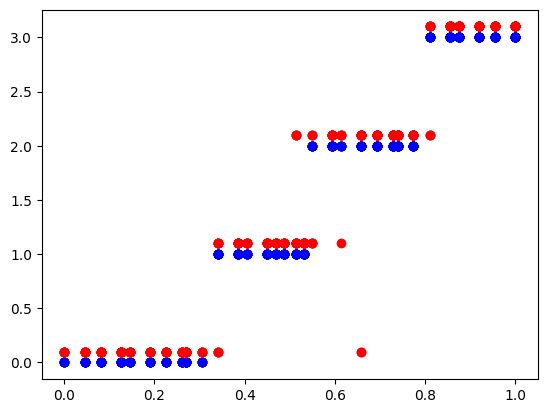

In [4]:
plt.scatter(session_data['value_function_continuous'], session_data['value_function'], c='b')
plt.scatter(session_data['value_function_continuous'], session_data['fss_01']+.1, c='r')


In [9]:
# load neural data
rate_data = load_neural_data(monkey, session, return_dataset_format=True)
rate_data = remove_trunctuated_neurons(rate_data, delay_limit=10)  # remove trunctuated units
#count_data = remove_low_fr_neurons(count_data, 1)  # remove low_firing units
rate_data = time_normalize_session(rate_data)  # normalize neural data in time
rate_data = scale_neural_data(rate_data)  # zscore neural data

if area != 'both':
    for data_var in rate_data.data_vars:
        rate_data[data_var] = rate_data[data_var][rate_data[data_var].area==area]

rate_data


<xarray.Dataset>
Dimensions:           (unit: 35, time: 255750)
Coordinates:
  * unit              (unit) <U10 'LPFC_06_01' 'LPFC_07_01' ... 'MCC_16_04'
  * time              (time) float64 8.01 10.87 13.74 ... 2.824e+03 2.824e+03
    unit_id_original  (unit) int64 7 17 24 28 25 78 30 ... 95 96 105 52 107 104
    channel           (unit) int64 6 7 11 12 12 13 13 ... 14 15 15 16 16 16 16
    area              (unit) <U4 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC' 'MCC'
    trial_id          (time) float64 0.0 0.0 0.0 0.0 ... 340.0 340.0 340.0 340.0
    epoch_id          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0 5.0
    time_in_trial     (time) float64 0.0 0.01 0.02 0.03 ... 7.46 7.47 7.48 7.49
Data variables:
    spike_trains      (unit, time) float64 nan nan nan ... -0.1021 -0.1021

In [10]:
def balance_trials(trial_ids, condition_vector):
    """
    Balance trials for each condition
    :param trial_ids: trial ids
    :param condition_vector: condition vector
    :return: balanced trial ids
    """
    # get trial ids for each condition
    condition_trial_ids = []
    for condition in np.unique(condition_vector):
        condition_trial_ids.append(trial_ids[condition_vector == condition])

    # get minimum number of trials for each condition
    min_num_trials = np.min([len(trial_ids) for trial_ids in condition_trial_ids])

    # balance trials for each condition
    balanced_trial_ids = []
    for condition_trial_ids in condition_trial_ids:
        balanced_trial_ids.append(np.random.choice(condition_trial_ids, min_num_trials, replace=False))

    # concatenate balanced trial ids
    balanced_trial_ids = np.concatenate(balanced_trial_ids)

    return balanced_trial_ids

# get equal number of trials for each condition
condition = 'fss_01'
#condition = 'value_function'

trial_ids_neural = np.unique(rate_data['trial_id'].values)
trial_ids_behavior = np.unique(session_data['trial_id'].values)
trial_ids = np.intersect1d(trial_ids_neural, trial_ids_behavior)

# condition vector for given trials
condition_vector = session_data[session_data['trial_id'].isin(trial_ids)][condition].values

# balance trials for each condition
trial_ids_balanced = balance_trials(trial_ids, condition_vector)
for condition_curr in np.unique(condition_vector):
    print(condition_curr, np.sum(condition_vector == condition_curr))

# get neural data for balanced trials
rate_data = rate_data.where(rate_data.trial_id.isin(trial_ids_balanced), drop=True)
session_data = session_data[session_data['trial_id'].isin(trial_ids_balanced)]

rate_data

0 84
1 82
2 84
3 86


<xarray.Dataset>
Dimensions:           (unit: 35, time: 246000)
Coordinates:
  * unit              (unit) <U10 'LPFC_06_01' 'LPFC_07_01' ... 'MCC_16_04'
  * time              (time) float64 327.8 327.8 327.8 ... 2.824e+03 2.824e+03
    unit_id_original  (unit) int64 7 17 24 28 25 78 30 ... 95 96 105 52 107 104
    channel           (unit) int64 6 7 11 12 12 13 13 ... 14 15 15 16 16 16 16
    area              (unit) <U4 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC' 'MCC'
    trial_id          (time) float64 5.0 5.0 5.0 5.0 ... 340.0 340.0 340.0 340.0
    epoch_id          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0 5.0
    time_in_trial     (time) float64 0.0 0.01 0.02 0.03 ... 7.46 7.47 7.48 7.49
Data variables:
    spike_trains      (unit, time) float64 nan nan nan ... -0.1021 -0.1021

# Transform data to PCA space

## Fit PCA

In [11]:
#data_to_fit = rate_data[:, rate_data.epoch_id.isin([2, 3, 4])].T
data_to_fit = rate_data.T

pca = PCA().fit(data_to_fit)
pca_data = pca.transform(rate_data.T).T
pca_data.shape
weights = pca.components_
explained_variance = pca.explained_variance_ratio_

AttributeError: 'Dataset' object has no attribute 'T'

In [17]:
# write back to xarray, with the unit_id coordinates changed to PC1, PC2, etc. all the other coordinates are the same
pca_data_xr = rate_data.copy(deep=True)
pca_data_xr.data = pca_data
pca_data_xr['unit'] = ['PC' + str(i) for i in range(1, pca_data.shape[0] + 1)]
pca_data_xr = pca_data_xr.rename({'unit': 'PCs'})
# new coordinate along 'unit' dimension called 'explained_variance'
pca_data_xr.coords['explained_variance'] = ('PCs', explained_variance)
pca_data_xr

<xarray.DataArray (PCs: 19, time: 246000)>
array([[-1.3184549 , -1.3184549 , -1.3714406 , ..., -0.8617502 ,
        -0.82629853, -0.78247297],
       [-0.04363482, -0.04363482,  0.13439533, ...,  0.60565764,
         0.50605595,  0.42592943],
       [-0.5517502 , -0.5517502 , -0.5073214 , ..., -0.97654724,
        -0.9772254 , -0.99105304],
       ...,
       [-0.22313194, -0.22313194, -0.1543312 , ...,  0.57014686,
         0.47987193,  0.37367737],
       [-0.48269197, -0.48269197, -0.38797766, ...,  0.0048332 ,
         0.0431518 ,  0.09796841],
       [ 0.25874427,  0.25874427,  0.27984732, ...,  0.2831135 ,
         0.1922339 ,  0.09288228]], dtype=float32)
Coordinates:
    trial_id            (time) float64 5.0 5.0 5.0 5.0 ... 340.0 340.0 340.0
    epoch_id            (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0
    area                (PCs) object 'MCC' 'MCC' 'MCC' ... 'MCC' 'MCC' 'MCC'
    unit_id_original    (PCs) int32 7 11 9 72 13 30 31 ... 95 96 105 52 107 104
    channel             (PCs) int32 4 5 5 6 6 9 10 10 ... 14 15 15 16 16 16 16
  * time                (time) float64 327.8 327.8 327.8 ... 2.824e+03 2.824e+03
  * PCs                 (PCs) <U4 'PC1' 'PC2' 'PC3' ... 'PC17' 'PC18' 'PC19'
    explained_variance  (PCs) float64 0.2424 0.06345 0.05928 ... 0.02561 0.02171
Attributes:
    bin_size:  0.01

## Demonstrate result

In [18]:
# build dataset
pca_dataset_xr, labels_all = build_dataset(pca_data_xr, session_data, n_extra_trials=1)


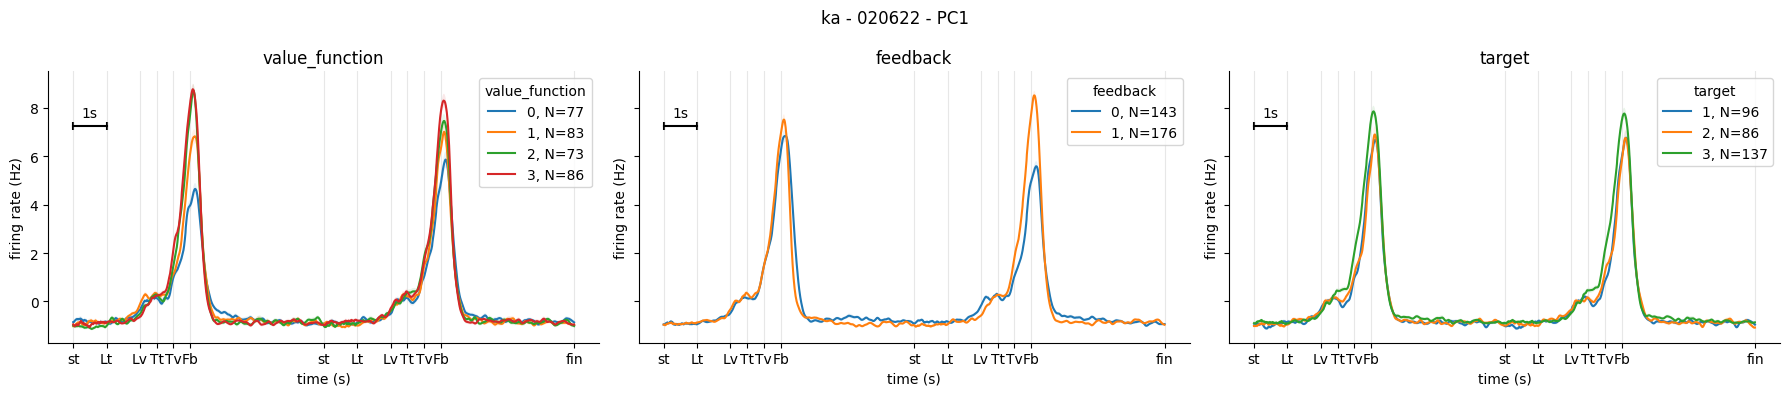

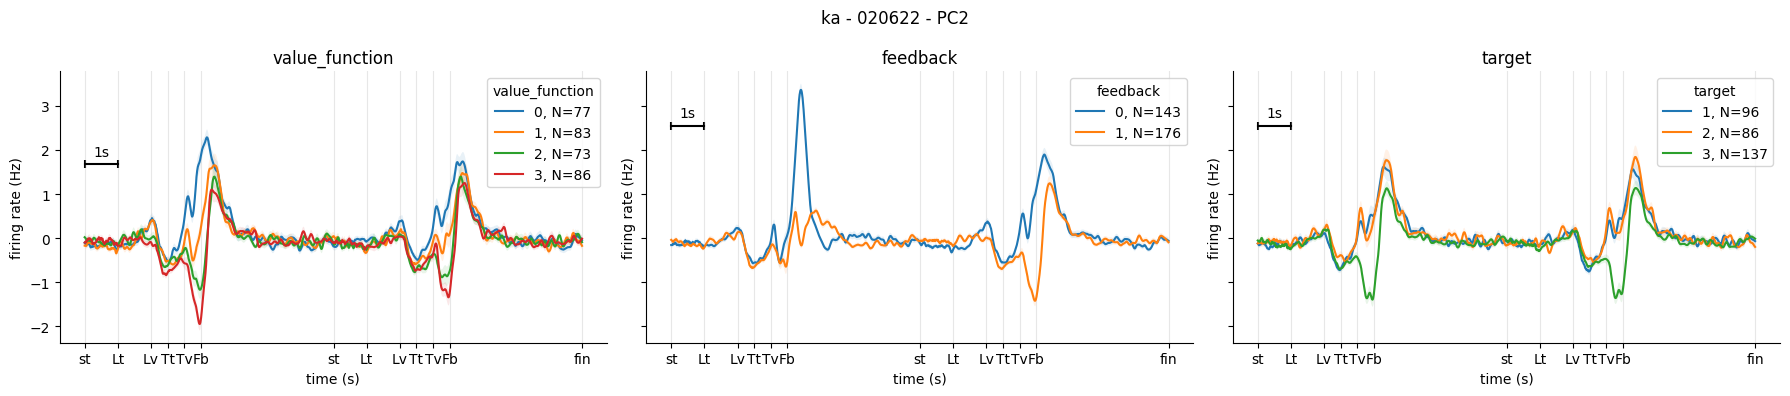

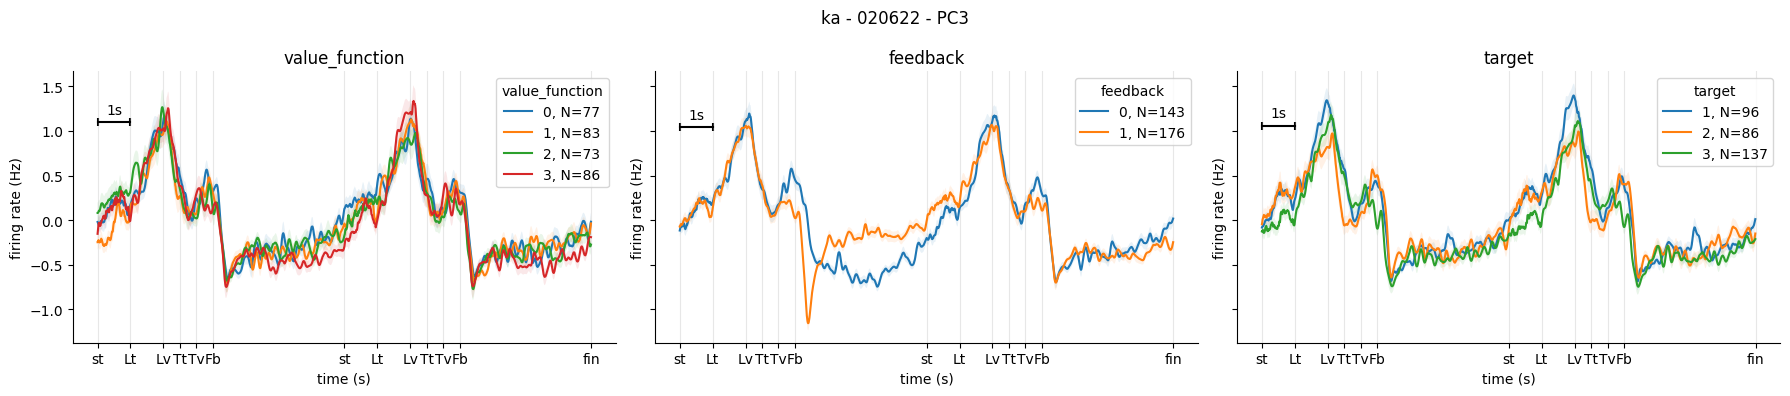

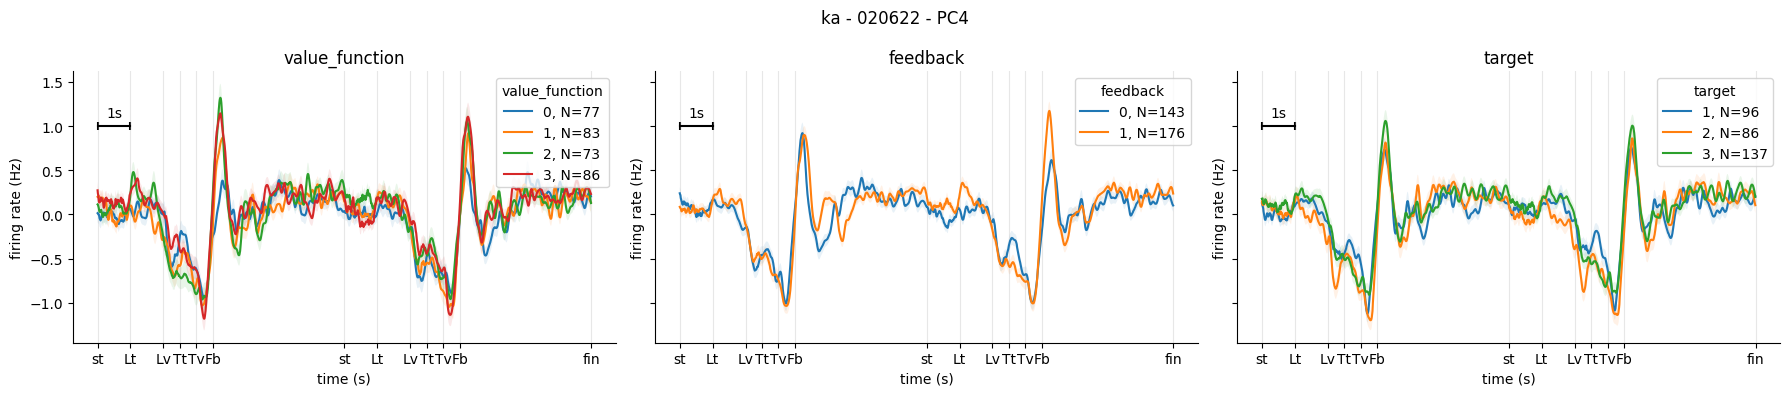

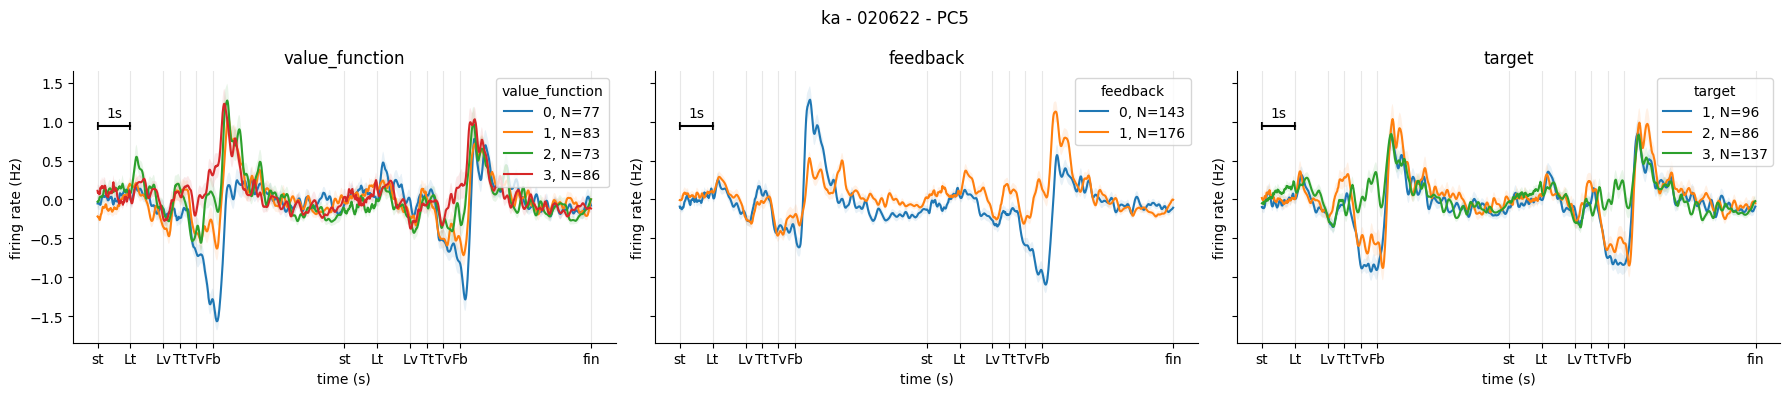

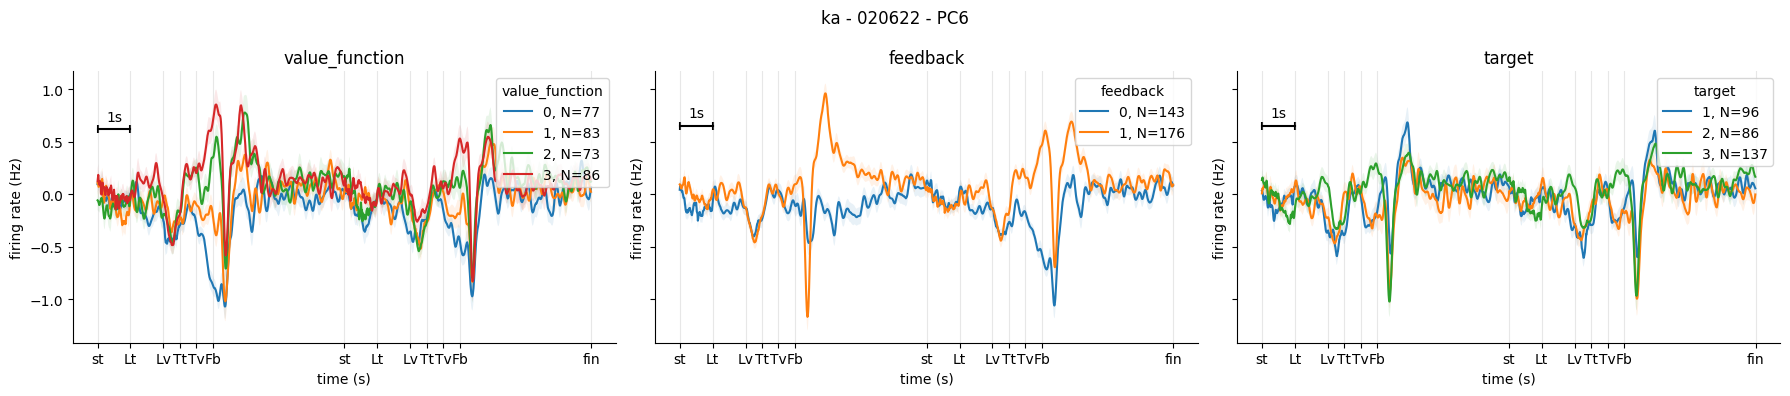

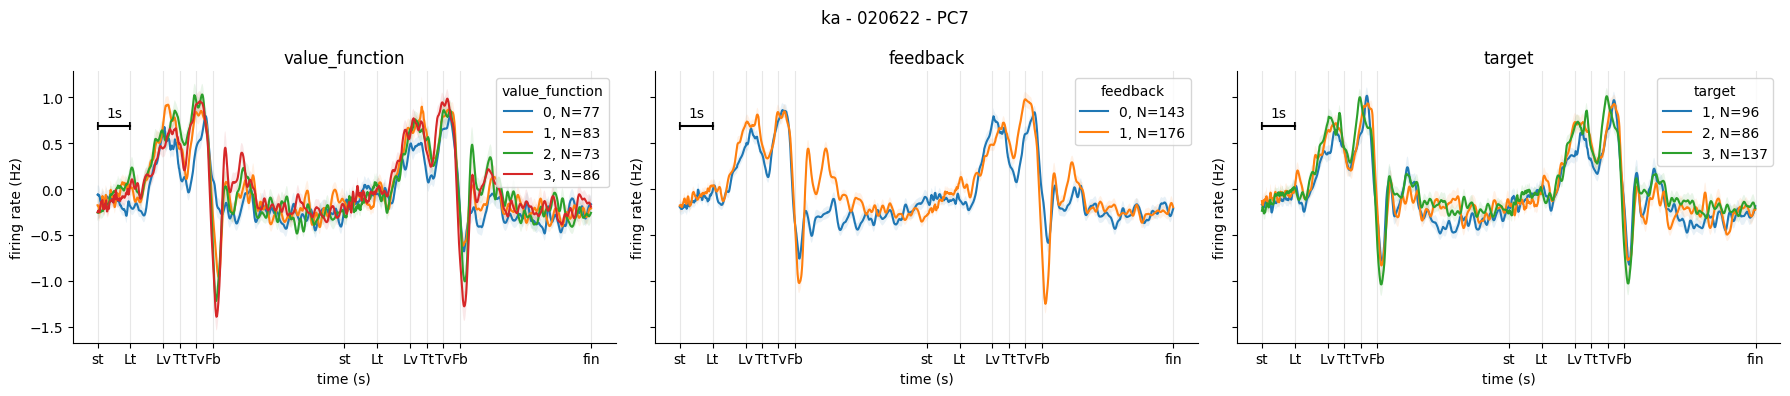

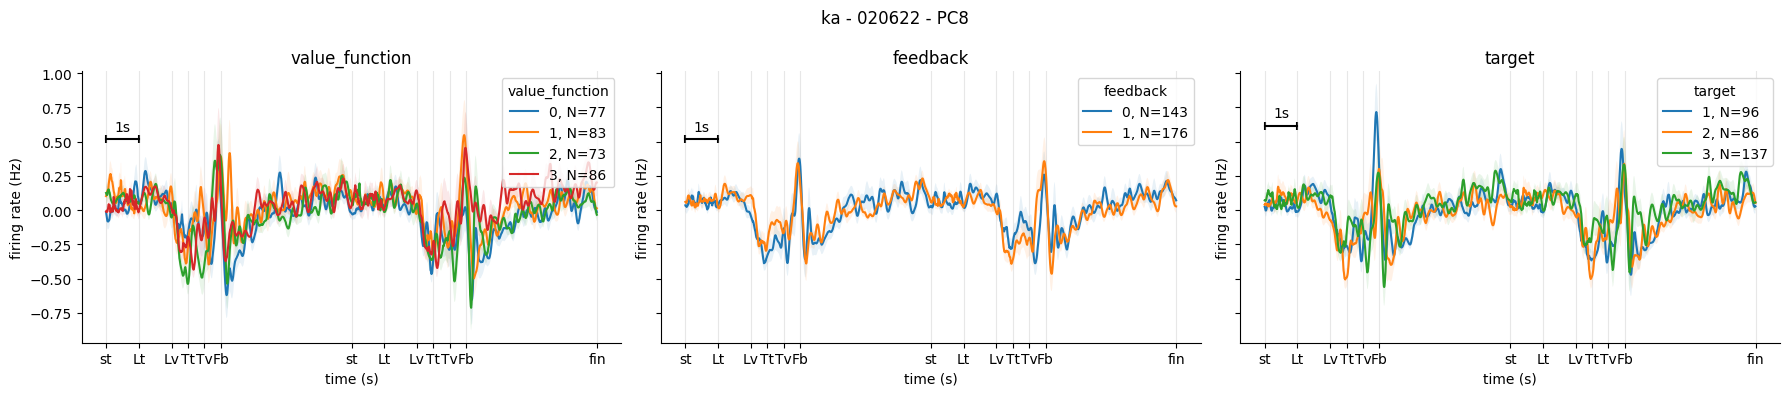

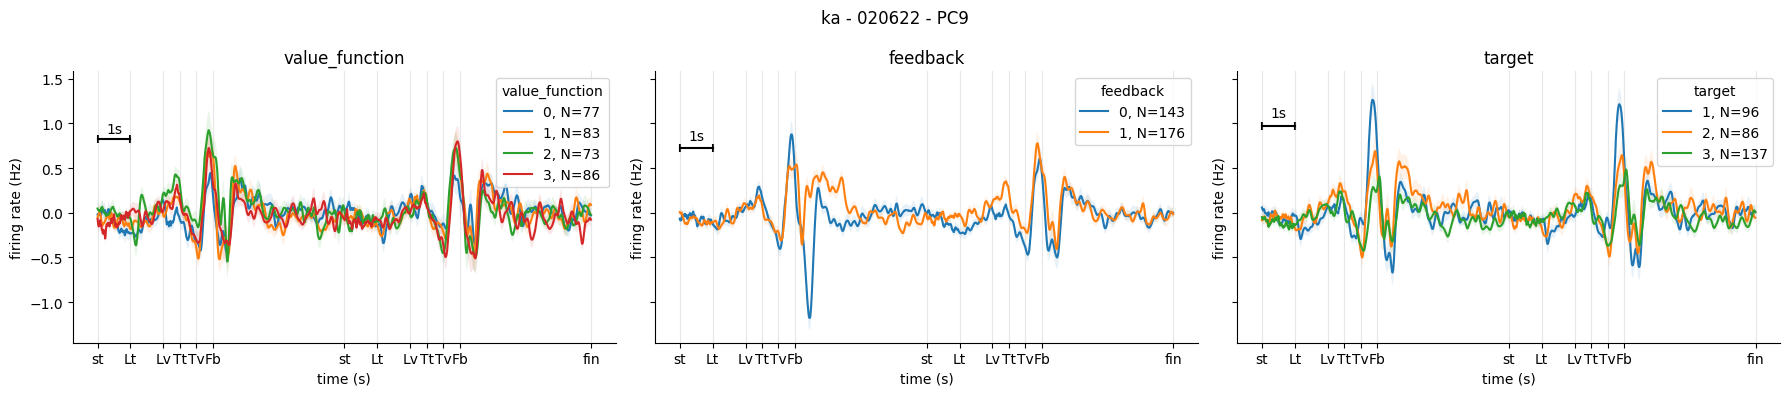

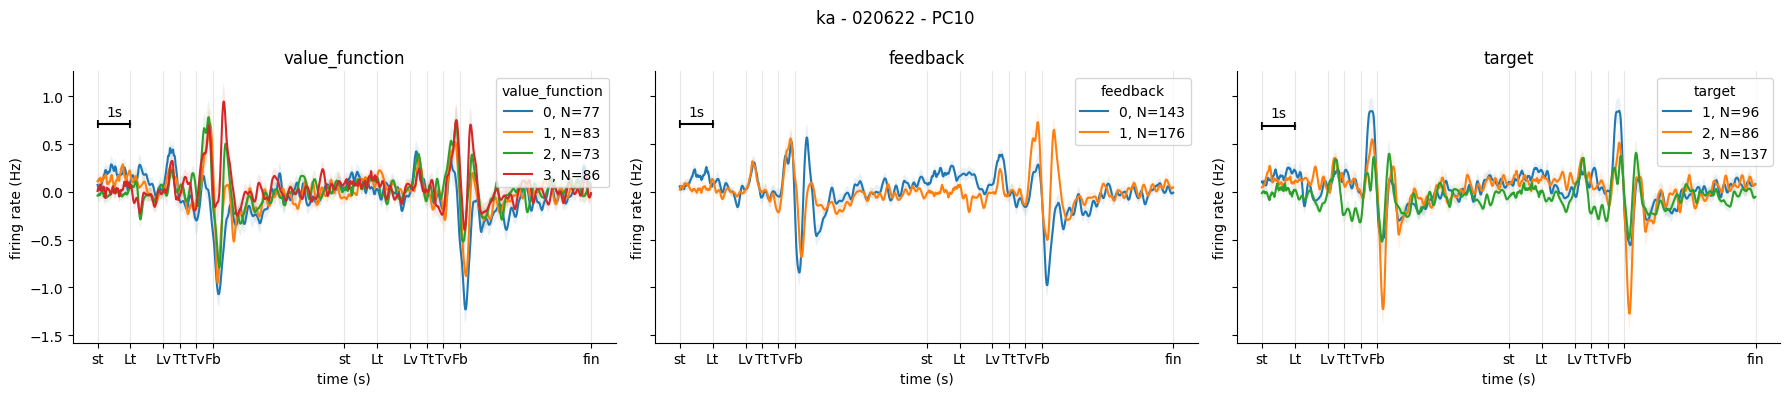

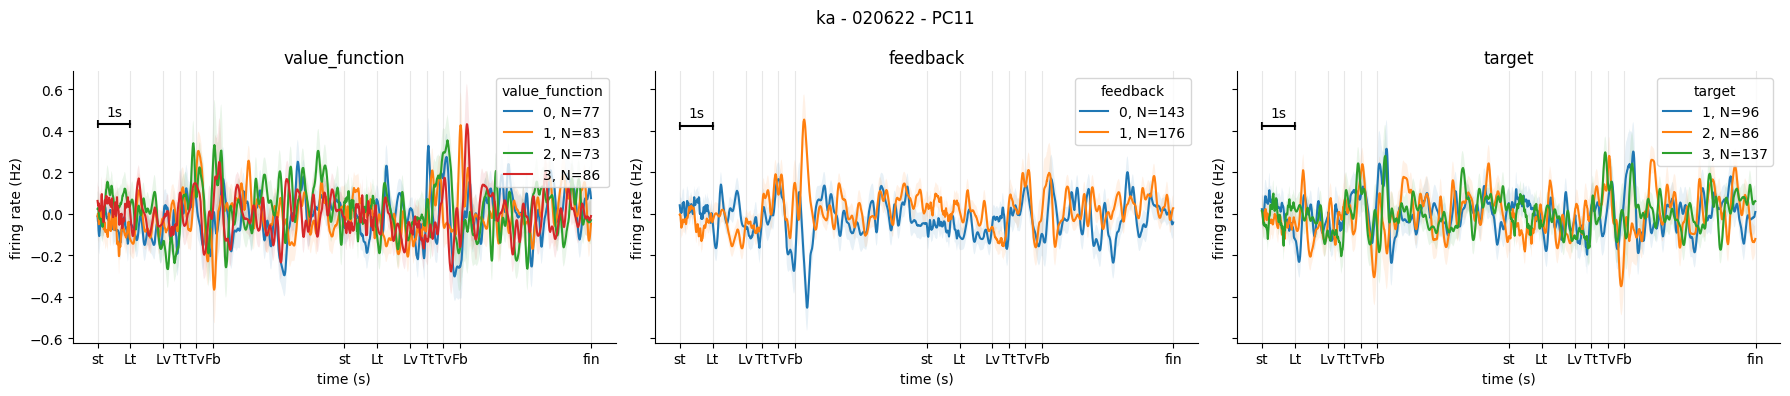

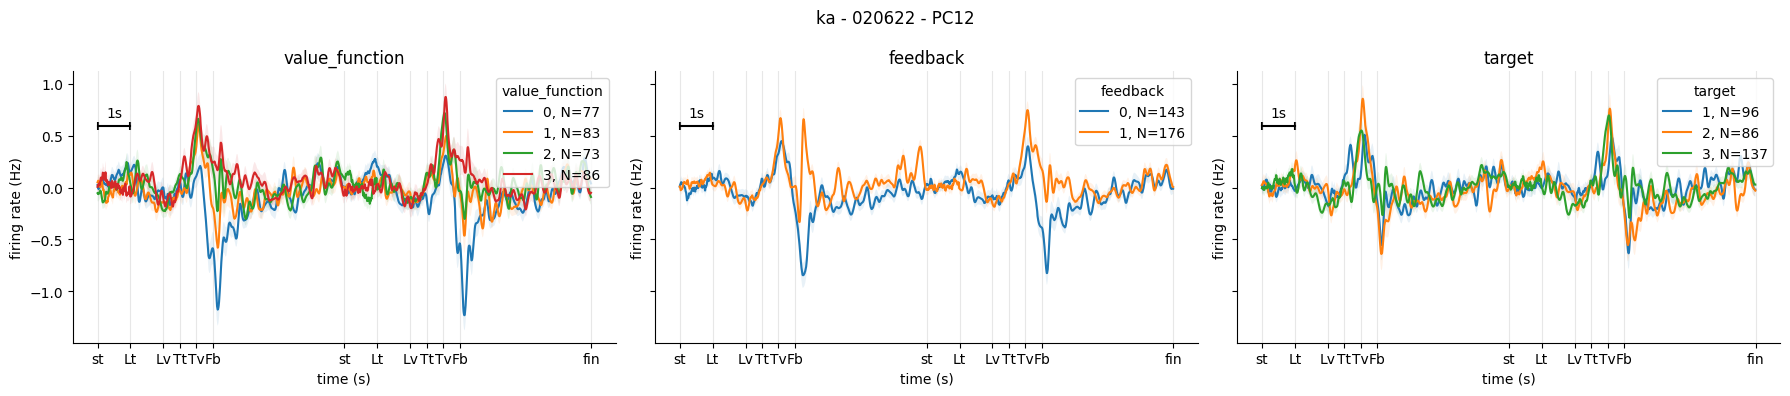

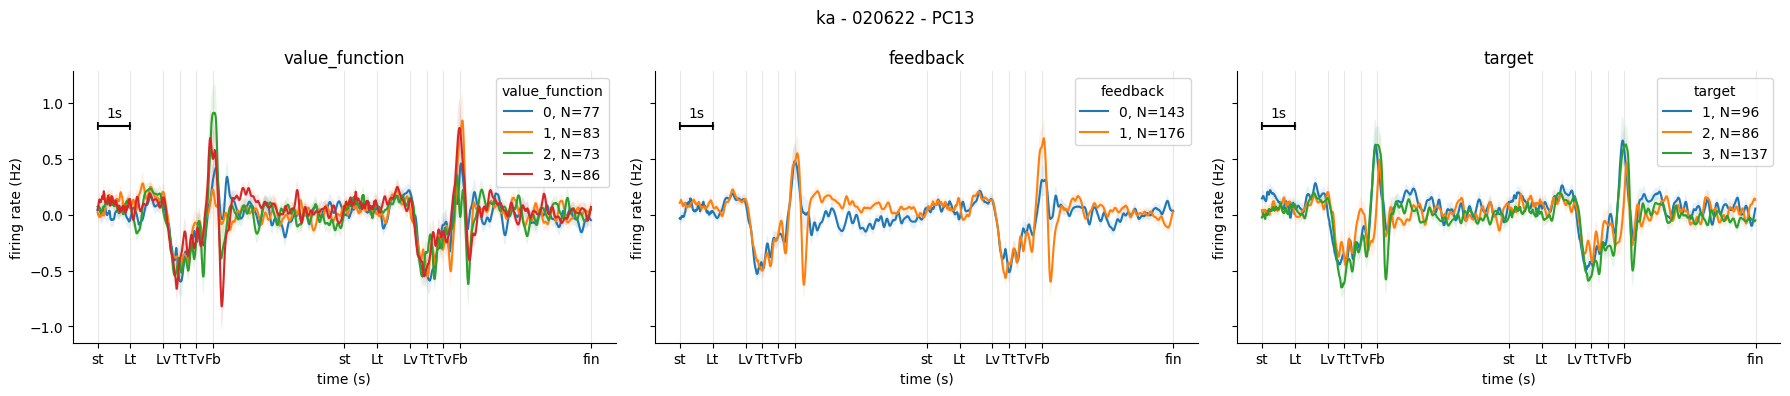

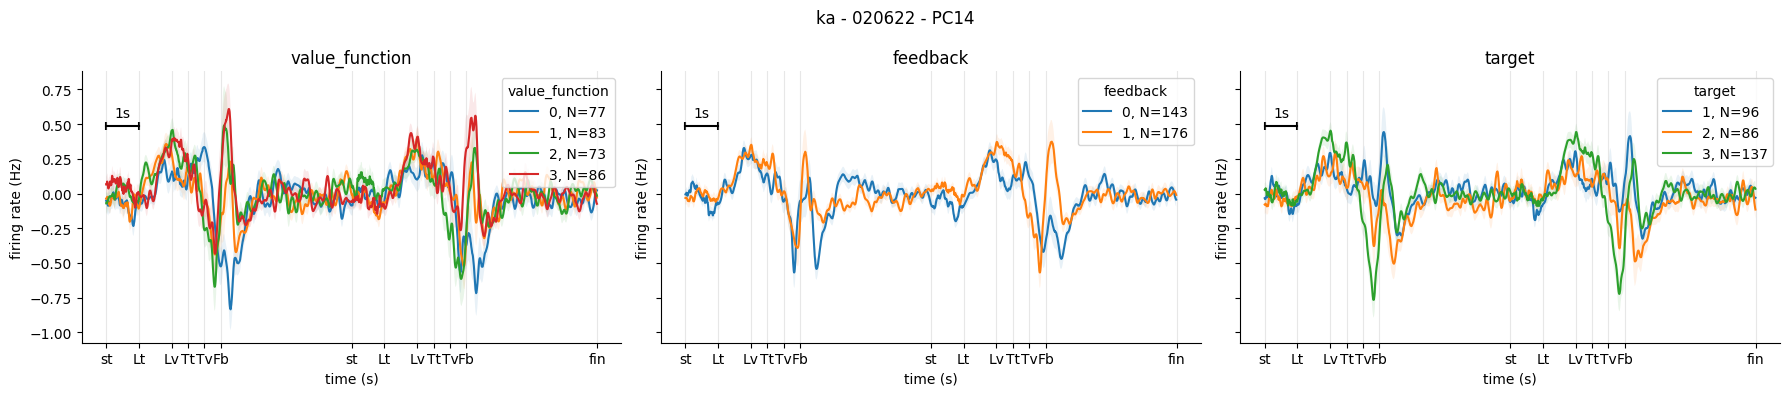

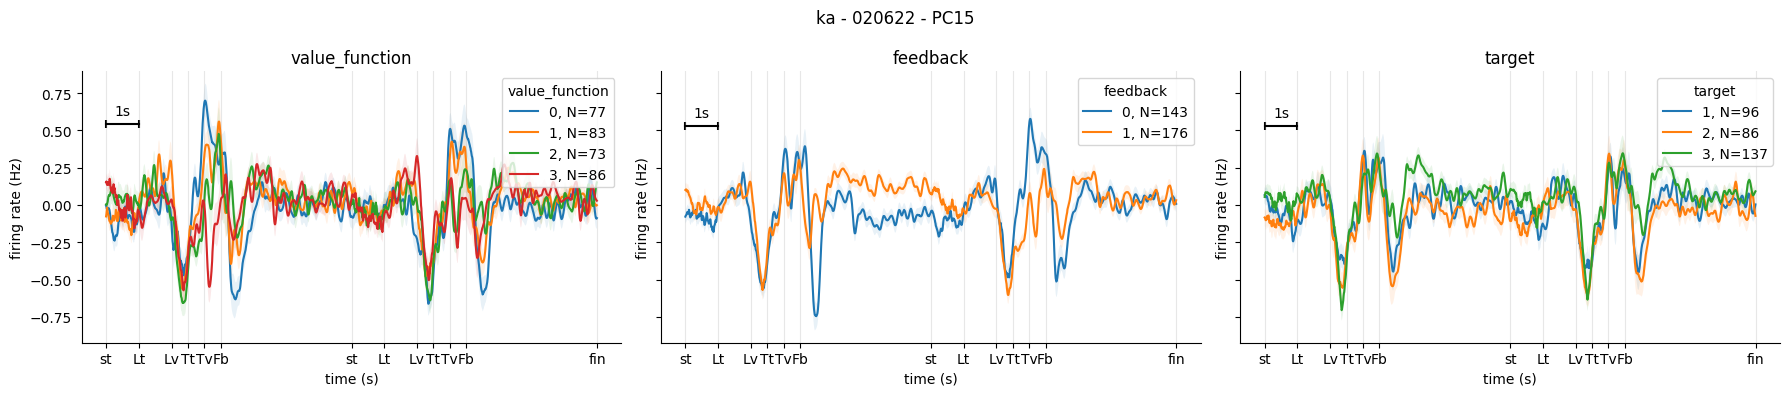

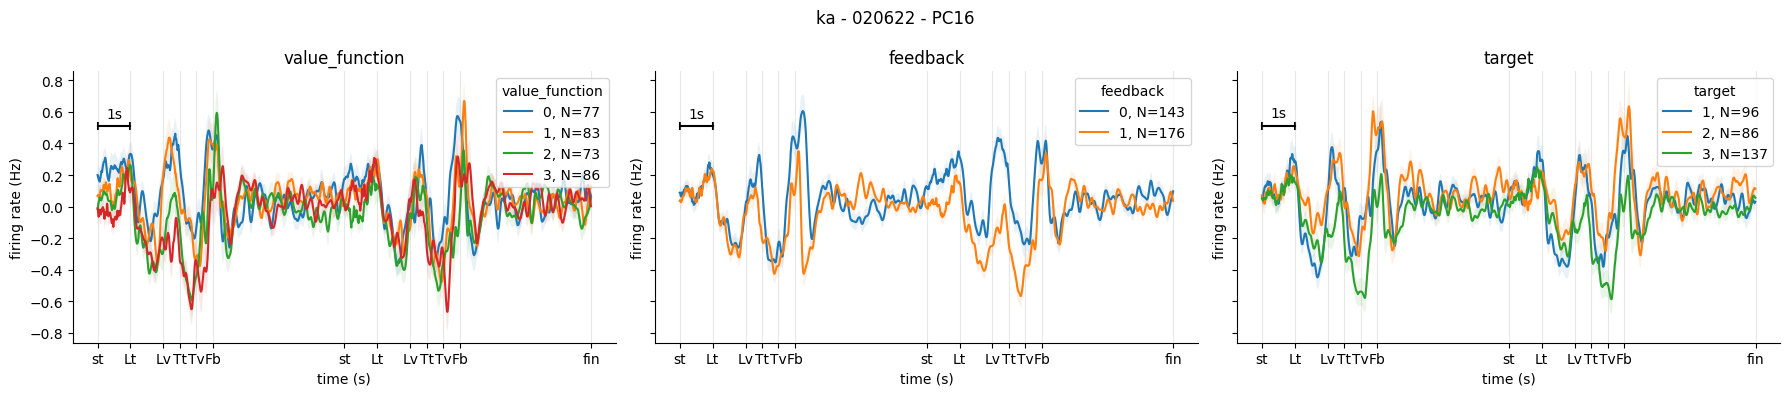

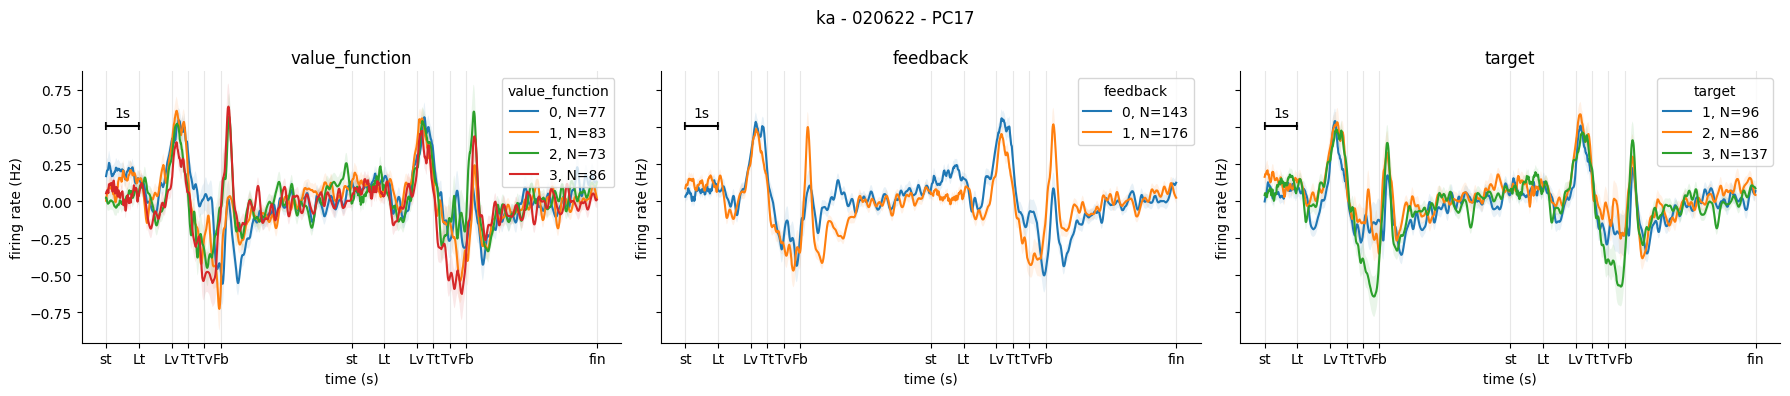

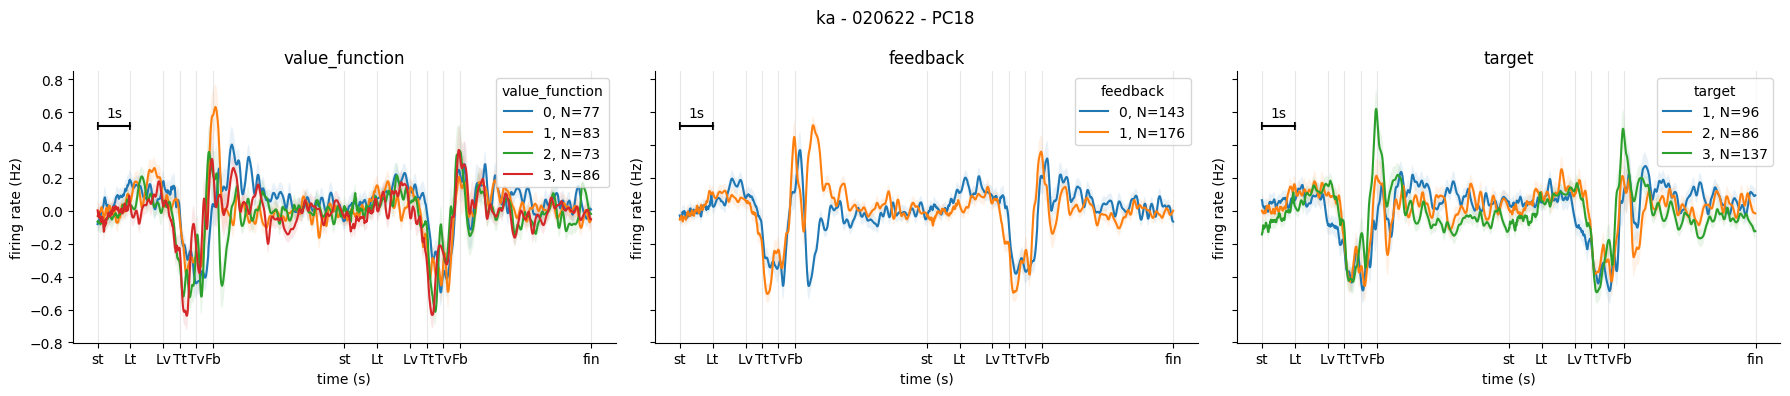

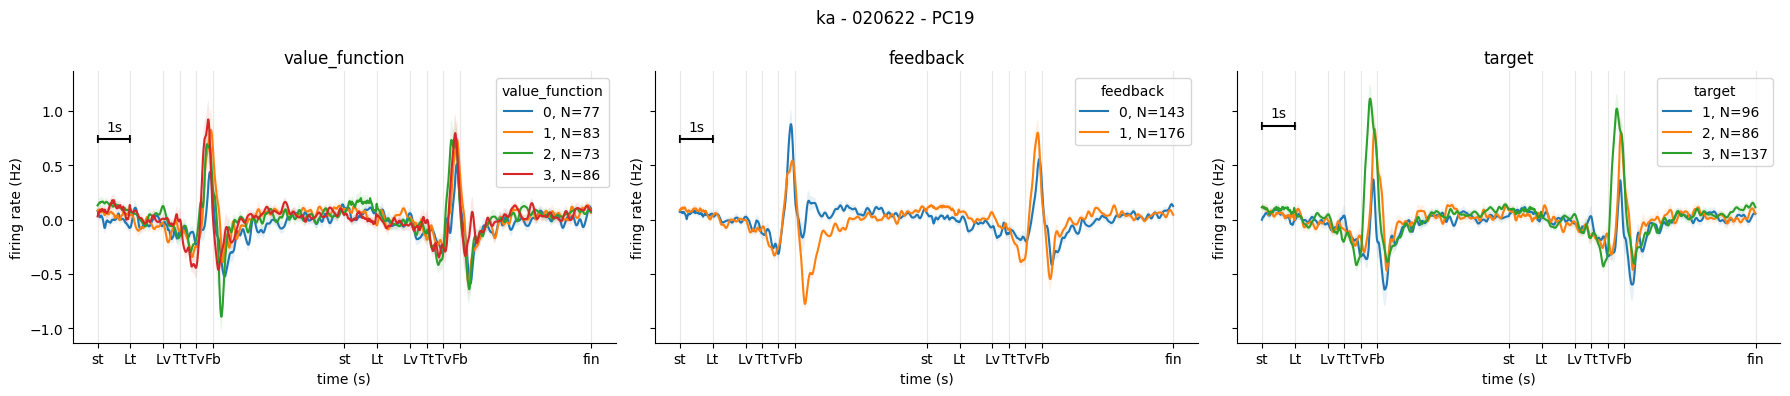

In [19]:
# get rate of unit
conditions = ['value_function', 'feedback', 'target']
for unit_idx, unit_name in enumerate(pca_dataset_xr.PCs.data):
    fig, axs = plt.subplots(1, len(conditions), figsize=(6*len(conditions), 4), sharey=True) 

    title = f'{monkey} - {session} - {unit_name} - explained variance: {pca_dataset_xr.explained_variance[unit_idx].data:.2f}'
    plt.suptitle(title, fontsize=12)

    # get this unit's data for valid trials - where there is no nan in the neural data of the trial
    non_nan_unit_data_ids = []
    for trial_id, trial_data in enumerate(pca_dataset_xr[:, unit_idx, :]):
        # if there is at least one non-nan value in the trial, keep it
        if np.sum(np.isnan(trial_data)) > 0:
            non_nan_unit_data_ids.append(False)
        else:
            non_nan_unit_data_ids.append(True)
    unit_data = pca_dataset_xr[non_nan_unit_data_ids, unit_idx, :]

    for cond_id, condition in enumerate(conditions):
        ax = axs[cond_id]

        # drop trials where unit didnt fire
        labels = labels_all[condition].values
        labels_valid = labels[non_nan_unit_data_ids]

        # drop trials where value is irrelevant
        non_nan_ids = labels_valid == labels_valid
        labels_valid = labels_valid[non_nan_ids]
        unit_data_temp = unit_data[non_nan_ids]

        # get time of interest
        tmin, tmax = 9.5, 12
        tmin, tmax = None, None
        if tmin is not None and tmax is not None:
            unit_data_temp = unit_data_temp[:, np.logical_and(pca_dataset_xr.time.data >= tmin, pca_dataset_xr.time.data <= tmax)]

        # only show units with at least 30 trials per condition
        trial_per_cond = np.unique(labels_valid, return_counts=True)[1]
        N = 1
        if np.min(trial_per_cond) < N:
            ax.set_title(f'Less than {N} trials per condition...')
            continue

        plot_single_unit(unit_data_temp, labels_valid, condition, title=condition, ax=ax)

        # plot mean firing rate by condition
        #ax.plot(np.linspace(tmin, tmax, unit_data[:, int(tmin/.01):int(tmax/0.01)].shape[-1]), np.mean(unit_data[:, int(tmin/.01):int(tmax/0.01)], axis=0), color='black', alpha=1, linewidth=1.5, label='mean (full session)')

    plt.tight_layout()
    plt.show()

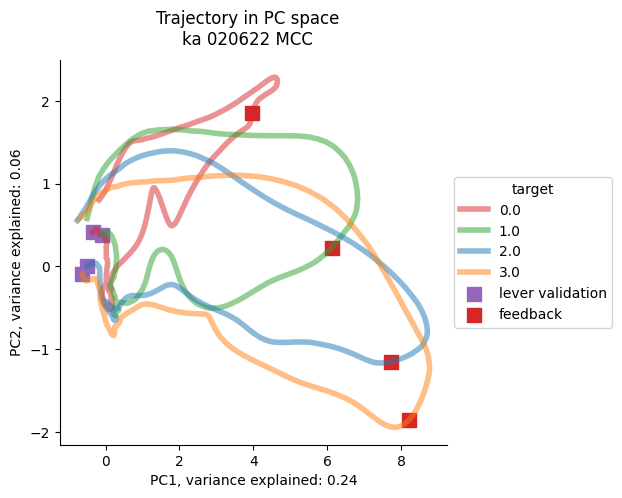

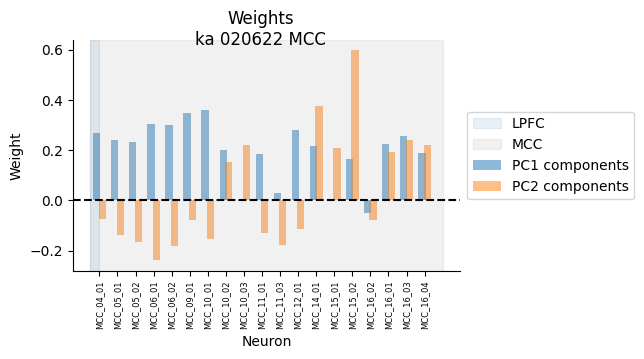

In [20]:
# plot, gouping by condition
ax0, ax1 = 0, 1
tmin, tmax = 200, 420

fig, axs = plt.subplots(1, 1, figsize=(5, 5), sharex=True)

time_vector = np.linspace(0, pca_dataset_xr.shape[2]*pca_data_xr.attrs['bin_size'], pca_dataset_xr.shape[2])

ax = axs
colors = {0: 'tab:red', 1: 'tab:green', 2: 'tab:blue', 3: 'tab:orange'}
labels_cond = labels_all['value_function'].values
for i, condition_curr in enumerate(np.unique(labels_cond)):
    rate_curr = pca_dataset_xr[labels_cond == condition_curr]
    rates_mean = np.mean(rate_curr, axis=0)
    
    # this matrix has 3 rows representing the 3 dimensions, and 750 time points representing the time. plot the trajectory of the 3D data
    ax.plot(rates_mean[ax0, tmin:tmax], rates_mean[ax1, tmin:tmax], label=condition_curr, color=colors[i], linewidth=4, alpha=0.5)

    # dot at  lever touch time==100 and fb time==350, square marker
    ax.scatter(rates_mean[ax0, 200], rates_mean[ax1, 200], color='tab:purple', s=100, marker='s', label='lever validation' if i==len(np.unique(labels_cond))-1 else '')
    ax.scatter(rates_mean[ax0, 350], rates_mean[ax1, 350], color='tab:red', s=100, marker='s', label='feedback' if i==len(np.unique(labels_cond))-1 else '')

ax.set_xlabel(f'PC{ax0+1}, variance explained: {explained_variance[ax0]:.2f}')
ax.set_ylabel(f'PC{ax1+1}, variance explained: {explained_variance[ax1]:.2f}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# box on the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=condition)
#plot_keypoints(ax)
plt.suptitle(f'Trajectory in PC space\n{monkey} {session} {area}')

fig.savefig(os.path.join(PATH, 'figs', 'cosyne', f'PCA_{monkey}_{session}.svg'), format='svg', dpi=300)



# plot weights
fig, axs = plt.subplots(1, 1, figsize=(5, 3), sharex=True)

ax = axs
ax.bar(np.arange(weights.shape[1])-.15, weights[ax0, :], width=.4, label='PC1 components', alpha=0.5)
ax.bar(np.arange(weights.shape[1])+.15, weights[ax1, :], width=.4, label='PC2 components', alpha=0.5)
ax.set_xlabel('Neuron')
ax.set_ylabel('Weight')

xticks = np.arange(weights.shape[1])
xticklabels = rate_data.unit.values
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels[xticks], rotation=90, fontsize=6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# box on the right
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='PCs')

#plot_keypoints(ax)
plt.suptitle(f'Weights\n{monkey} {session} {area}')
ax.axhline(0, color='k', linestyle='--')
n_LPFC = np.sum(rate_data.area.values == 'LPFC') -.5
# set background color below x==n_LPFC to blue, above to grey
ax.axvspan(0, n_LPFC, color='tab:blue', alpha=0.1, label='LPFC')
ax.axvspan(n_LPFC, weights.shape[1], color='tab:grey', alpha=0.1, label='MCC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save



In [21]:
from sklearn.cross_decomposition import CCA

X = pca_data_xr.T
Y = rate_data.T

cca = CCA(n_components=1)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
X_c, Y_c = X_c.T, Y_c.T

In [22]:
plt.figure(figsize=(5, 5))
plt.plot(X_c[0, :], X_c[1, :])
plt.xlabel('CCA 1')
plt.ylabel('CCA 2')
plt.grid()

IndexError: index 1 is out of bounds for axis 0 with size 1

<Figure size 500x500 with 0 Axes>

In [ ]:
# prepare data for plotting

#T_mean = pca.transform(np.mean(X_cond_temp, axis=0).T)  # transform mean activity, this will be subtracted from the conditional activity

# df to collect PCA trajectories for plottingresults per condition
T_all = pd.DataFrame(columns=['feedback',  'target', 'switch', 'value_function_digit'],
                          index=[area])

n_components = 4  # number of components to use for plotting
for condition in T_all.columns:
    T_full, labels = build_dataset(PCA_data, behav_data, 
                                   starts_on='fb-1', ends_on='fb+1',
                                   target_name=condition)

    T_current = {}
    # get mean trial activity per condition
    for label in np.unique(labels):
        T_temp = np.mean(T_full[labels == label], axis=0)  # mean activity per condition
        #T_temp = T_temp - T_mean  # subtract full mean activity
        T_current[label] = T_temp[:n_components, :]  # save only the first n_components
    T_all[condition][area] = T_current

In [ ]:
# plot
title = f'Representation of conditions in PC space, {monkey} {session} {area} {pca_of_interest} (cond: {pca_of_interest} PCA)'
show_PCA_trajectories(neural_data, T_all, pca.explained_variance_ratio_, n_components=n_components, title=title)

# Inspect decision space

## Correlation between time, target and PC activities   

In [ ]:
"""target_vector = behav_data['target'].values
trial_id_vector = behav_data['trial_id'].values
time_vector = behav_data['target_touch_time'].values"""

# correlate time with target
from scipy.stats import spearmanr

trial_id_vector = behav_data['trial_id'].values
target_vector = behav_data['target'].values

# plot distribution of target across trials
distributions = {target: [] for target in np.unique(target_vector)}
for target in np.unique(target_vector):
    for i in range(len(trial_id_vector)-40):
        targets_temp = target_vector[i:i+40]
        distributions[target].append(np.sum(targets_temp == target))

# correlate time with activities
corr_PC = np.corrcoef(PCA_data.values, PCA_data.time.values)
corr_PC = corr_PC[:PCA_data.shape[0], -1]
corr_PC = np.abs(corr_PC)

corr_neural = np.corrcoef(neural_data_area.values, neural_data_area.time.values)
corr_neural = corr_neural[:neural_data_area.shape[0], -1]
corr_neural = np.abs(corr_neural)

# plot
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].bar(np.arange(0, neural_data_area.shape[0]), corr_neural)
ax[0, 0].set_xlabel('neuron')
ax[0, 0].set_ylabel('Correlation with time (abs)')
ax[0, 0].set_title(f'Correlation of neurons with time, {monkey} {session} {area}')

ax[0, 1].bar(np.arange(0, PCA_data.shape[0]), corr_PC)
ax[0, 1].set_xlabel('PC')
ax[0, 1].set_ylabel('Correlation with time (abs)')
ax[0, 1].set_title(f'Correlation of PCs with time, {monkey} {session} {area}')

# plot pca weights
im = ax[1, 0].imshow(np.abs(pca.components_), aspect='auto', cmap='binary')
# colorbar
cbar = fig.colorbar(im, ax=ax[1, 0])
cbar.set_label('weight (abs)')
ax[1, 0].set_xlabel('neurons')
ax[1, 0].set_ylabel('PCs')
ax[1, 0].set_title(f'PCA weights, {monkey} {session} {area}')

# plot distribution of targets
for target in np.unique(target_vector):
    data = distributions[target]
    # smooth
    data = np.convolve(data, np.ones((10,))/10, mode='valid')
    ax[1, 1].plot(data, label=f'target {target}')
ax[1, 1].legend(loc='upper right')
ax[1, 1].set_xlabel('trial')
ax[1, 1].set_ylabel('number of selection (in a window of 40 trials)')
ax[1, 1].set_title(f'Distribution of targets across trials, {monkey} {session}')
plt.show()

## Plotting decision space

In [ ]:
# print activity by condition
def find_max_sep(T_full, y, pc=0, show=False):
    # find time of max separation
    max_sep = 0
    for t in range(T_full.shape[2]):
        all_activities = [np.mean(T_full[y == label, pc, t]) for label in np.unique(y)]
        max_sep_temp = np.abs(np.max(all_activities) - np.min(all_activities))
        if max_sep_temp > max_sep:
            max_sep = max_sep_temp
            t_max = t
    
    if show:
        for label in np.unique(y):
            plt.plot(np.mean(T_full[y == label, pc, :], axis=0), label=label)
        # vertival line at t_max
        plt.axvline(x=t_max, color='k', linestyle='--')
        plt.legend()
        plt.title(f'PC{pc} activity by condition')
        plt.grid()
        plt.show()
    return t_max

In [ ]:
# split PCA data by trial
T_full = np.array([PCA_data[:, PCA_data.trial_id == trial] for trial in np.unique(PCA_data.trial_id)])

# extract one activity vector per trial
# 1. trial mean represents the activity of the trial
T_repres_mean = np.mean(T_full, axis=2)
# 2. time of best separation describes the activity of the trial
pc_of_interest = 2
t_max = find_max_sep(T_full, behav_data[condition_of_interest], pc_of_interest, show=True)
T_repres_best = T_full[:, :, t_max]

In [ ]:
# plot in 2d space
data = T_repres_best  # data to plot
pcs_of_interests = [1, 2]  # PCs to plot

# define colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
colors_dict = {label: colors[i] for i, label in enumerate(np.unique(behav_data[condition_of_interest]))}

fig, ax = plt.subplots(figsize=(10, 10))

colors_vector = [colors_dict[y] for y in behav_data[condition_of_interest]]
# show all points
ax.scatter(data[:, pcs_of_interests[0]], data[:, pcs_of_interests[1]], c=colors_vector, alpha=0.7)

# show mean
for label in np.unique(behav_data[condition_of_interest]):
    ax.scatter(np.mean(data[behav_data[condition_of_interest] == label, pcs_of_interests[0]]),
               np.mean(data[behav_data[condition_of_interest] == label, pcs_of_interests[1]]),
               c=colors_dict[label], s=100, marker='x', linewidth=30)

# legend
for label in np.unique(behav_data[condition_of_interest]):
    ax.scatter([], [], c=colors_dict[label], label=f"{condition_of_interest}: {label}")
ax.scatter([], [], c='black', marker='x', label='mean')
ax.legend()

# show time as lines
for i in range(len(data)-1):
    ax.plot(data[i:i+2, pcs_of_interests[0]], data[i:i+2, pcs_of_interests[1]], c='black', alpha=.05)

ax.set_xlabel(f'PC {pcs_of_interests[0]}')
ax.set_ylabel(f'PC {pcs_of_interests[1]}')
ax.set_title(f'Single trial mean activity in the decision space, N trials: {data.shape[0]} {monkey} {session} {area} {pca_of_interest}')
plt.show()

In [ ]:
# correlate value function with activity at PC_N
value_function = behav_data['value_function']
time_vector = (behav_data['trial_id'] - behav_data['trial_id'].min()) / (behav_data['trial_id'].max() - behav_data['trial_id'].min())

label_vector = time_vector

pc_activity = T_repres_best[:, pc_of_interest]
# minmax normalize
pc_activity = (pc_activity - np.min(pc_activity)) / (np.max(pc_activity) - np.min(pc_activity))

plt.scatter(label_vector, pc_activity)
plt.xlim(-.05, 1.05)
plt.ylim(-.05, 1.05)
plt.xlabel('value function')
plt.ylabel(f'PC{pc_of_interest+1} activity')
plt.title(f'Correlation between value function and PC{pc_of_interest+1} activity, {monkey} {session} {area} {pca_of_interest}')
plt.show()

# compute pearson correlation
from scipy.stats import pearsonr
print("Pearson correlation between ... and PC activity:",
        pearsonr(label_vector, pc_activity))